# Import libraries 

In [42]:
from keras.models import Model 
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input , decode_predictions
from keras.preprocessing import image 
from keras.utils import load_img , img_to_array
import numpy as np 
import scipy as sp
import matplotlib.pyplot as plt 
from glob import glob 

# Downloading the image files 

In [21]:
!tar -xzvf 101_ObjectCategories.tar.gz

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
101_ObjectCategories/chair/image_0005.jpg
101_ObjectCategories/chair/image_0006.jpg
101_ObjectCategories/chair/image_0007.jpg
101_ObjectCategories/chair/image_0008.jpg
101_ObjectCategories/chair/image_0010.jpg
101_ObjectCategories/chair/image_0011.jpg
101_ObjectCategories/chair/image_0012.jpg
101_ObjectCategories/chair/image_0013.jpg
101_ObjectCategories/chair/image_0014.jpg
101_ObjectCategories/chair/image_0016.jpg
101_ObjectCategories/chair/image_0017.jpg
101_ObjectCategories/chair/image_0018.jpg
101_ObjectCategories/chair/image_0019.jpg
101_ObjectCategories/chair/image_0020.jpg
101_ObjectCategories/chair/image_0022.jpg
101_ObjectCategories/chair/image_0023.jpg
101_ObjectCategories/chair/image_0024.jpg
101_ObjectCategories/chair/image_0025.jpg
101_ObjectCategories/chair/image_0026.jpg
101_ObjectCategories/chair/image_0028.jpg
101_ObjectCategories/chair/image_0029.jpg
101_ObjectCategories/chair/image_0030.jp

In [22]:
image_files = glob("101_ObjectCategories/*/*.jp*g")

In [24]:
len(image_files)

9144

## Checking an image : 

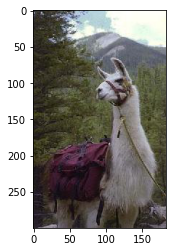

In [26]:
plt.imshow(load_img(np.random.choice(image_files)))
plt.show()

In [28]:
img_to_array(load_img(np.random.choice(image_files))).shape

(452, 685, 3)

# Model 

In [29]:
resnet = ResNet50(input_shape=(224,224,3), weights= "imagenet", include_top=True)
resnet.summary()

102967424/102967424 [==============================] - 3s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

In [41]:
activation_layer= resnet.get_layer("conv5_block3_out")

#create a model object : 
model =Model(inputs=resnet.input, outputs=activation_layer.output)
final_dense = resnet.get_layer("predictions")
W=final_dense.get_weights()[0]


In [65]:
count=0
while True : 
    img=load_img(np.random.choice(image_files), target_size=(224,224))
    x=preprocess_input(np.expand_dims(img,0))
    fmaps=model.predict(x)[0]# 7 x 7 x 2048

    #get predicted class : 
    probs= resnet.predict(x)
    classnames =decode_predictions(probs)[0]
    #print(classnames)
    classname = classnames[0][1]
    pred=np.argmax(probs[0])

    w=W[:,pred]

    cam=fmaps.dot(w)#currently a 7 x 7 image 

    # upsample to 224 x 224
    # 7 x 32 = 224 , we zoom to have same sizes images 
    cam  = sp.ndimage.zoom(cam, (32,32), order=1)

    #Ploting results 
    plt.subplot(1,2,1)
    plt.imshow(img, alpha=0.8)
    plt.imshow(cam,cmap="jet", alpha=0.5)
    plt.subplot(1,2,2)
    plt.imshow(img)
    plt.title(classname)
    plt.show()

    count+=1
    if count==20: 
        break 

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def slowversion(A,w): 
    n=len(w)
    result= np.zeros(A.shape[:-1])
    for i in range(n): 
        result+= A[:,:,i]*w[i]
    return result